In [2]:
import numpy as np
import ROOT
from math import exp as expo
from math import cos as cosine
exp=np.vectorize(expo)
cos=np.vectorize(cosine)
import matplotlib.pylab as plt
from matplotlib.pyplot import figure
from BlindersPy3 import Blinders
from BlindersPy3 import FitType
import scipy.optimize as opt

Welcome to JupyROOT 6.24/06


In [3]:
file = ROOT.TFile.Open("run3a_NE_305stop.root")
#direc = file.Get("QFillByFillAnalyzerDB")
hist = ROOT.TH1D()
hist = file.Get("calo_histogram_sum_ratio")
hcov = ROOT.TH2D()
hcov = file.Get("hcov")



In [4]:
getBlinded = Blinders(FitType.Omega_a, "Ritwika's new  Blinding")

 + ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ +
 +                                                                      +
 +           You have chose to blind your fitting according to          +
 +                omega_ref * (1 + (R +/- deltaR) *10^{-6})             +
 +                                                                      +
 + ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ +


In [5]:
fit_start=30000
fit_stop=305000
fit_range=hist.FindBin(fit_stop)-hist.FindBin(fit_start)+1

T_a_true=4365.411
nbinshift=int((0.5*T_a_true)/hist.GetBinWidth(1))
T_a=2*nbinshift*hist.GetBinWidth(1)

y_val=np.empty(fit_range)
y_err=np.empty(fit_range)
x_val=np.empty(fit_range)

for ibin in range (0,fit_range):
    y_val[ibin]=hist.GetBinContent(ibin+hist.FindBin(fit_start))
    y_err[ibin]=hist.GetBinError(ibin+hist.FindBin(fit_start))
    x_val[ibin]=hist.GetBinCenter(ibin+hist.FindBin(fit_start))
    

y_cov = np.empty(shape=(fit_range,fit_range))

for irow in range (0, fit_range):
      for icol in range(0, fit_range):
            y_cov[irow][icol]=hcov.GetBinContent(irow+hist.FindBin(fit_start),icol+hist.FindBin(fit_start))

In [6]:
print(y_cov[0][0])
mat=np.linalg.eigvalsh(y_cov)
for irow in range (0, fit_range):
    if mat[irow]<=0:
        print(irow,"\n")

3.1864095276718523e-09


In [7]:
def fit_func(time: np.double,
             asym: np.double = 0.0, 
             R: np.double = 0.0, 
             phi: np.double = 0.0,
             asym_cbo = 0.0,
             tau_cbo = 0.0,
             omega_cbo = 0.0,
             phi_cbo = 0.0,
             asym_cbo_A = 0.0,
             phi_cbo_A=0.0,
             A_cbo_phi= 0.0,
             phi_cbo_phi=0.0,
             asym_vw= 0.0,
             tau_vw = 0.0,
             omega_vw = 0.0,
             phi_vw = 0.0,
             asym_vbo= 0.0,
             tau_vbo = 0.0,
             omega_vbo = 0.0,
             phi_vbo = 0.0,
             asym_2cbo= 0.0,
             phi_2cbo = 0.0,
             tau_rlx = 0.0,
             A_cbot = 0.0,
             tau_cbot = 0.0,
             A_cbovw = 0.0,
             phi_cbovw = 0.0,
             A_drift = 0.0)-> np.double:
    
    tau_cbovw = 17680
    omega_cbovw = 0.012
    
    tau_drift = 21000
    
    omega_cbot=omega_cbo*(1+A_cbot*exp(-time/tau_cbot))
    omega_cbotf=omega_cbo*(1+A_cbot*exp(-(time+T_a/2)/tau_cbot))
    omega_cbotb=omega_cbo*(1+A_cbot*exp(-(time-T_a/2)/tau_cbot))
    
    Ncbo=(1 + asym_cbo*exp(-time/tau_cbo)*cos(omega_cbot*time - phi_cbo))
    Ncbof=(1+ asym_cbo*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbotf*(time + T_a/2) - phi_cbo))
    Ncbob=(1+ asym_cbo*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbotb*(time - T_a/2) - phi_cbo))
    
    Acbo=(1+ asym_cbo_A*exp(-time/tau_cbo)*cos(omega_cbot*time - phi_cbo_A));
    Acbof=(1+ asym_cbo_A*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbotf*(time + T_a/2) - phi_cbo_A))
    Acbob=(1+ asym_cbo_A*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbotb*(time - T_a/2) - phi_cbo_A))
    
    phicbo=(A_cbo_phi*exp(-time/tau_cbo)*cos(omega_cbot*time - phi_cbo_phi))
    phicbof=(A_cbo_phi*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbotf*(time + T_a/2) - phi_cbo_phi))
    phicbob=(A_cbo_phi*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbotb*(time - T_a/2) - phi_cbo_phi))
    
    Nvw=(1+ asym_vw*exp(-time/tau_vw)*cos(omega_vw*time - phi_vw))
    Nvwf=(1+ asym_vw*exp(-(time + T_a/2)/tau_vw)*cos(omega_vw*(time + T_a/2) - phi_vw))
    Nvwb=(1+ asym_vw*exp(-(time - T_a/2)/tau_vw)*cos(omega_vw*(time - T_a/2) - phi_vw))
    
    Nvbo=(1+ asym_vbo*exp(-time/tau_vbo)*cos(omega_vbo*time - phi_vbo))
    Nvbof=(1+ asym_vbo*exp(-(time + T_a/2)/tau_vbo)*cos(omega_vbo*(time + T_a/2) - phi_vbo))
    Nvbob=(1+ asym_vbo*exp(-(time - T_a/2)/tau_vbo)*cos(omega_vbo*(time - T_a/2) - phi_vbo))
    
    N2cbo=(asym_2cbo*exp(-2*time/tau_cbo)*cos(2*omega_cbot*time - phi_2cbo))
    N2cbof=(asym_2cbo*exp(-2*(time + T_a/2)/tau_cbo)*cos(2*omega_cbotf*(time + T_a/2) - phi_2cbo))
    N2cbob=(asym_2cbo*exp(-2*(time - T_a/2)/tau_cbo)*cos(2*omega_cbotb*(time - T_a/2) - phi_2cbo))
    
    Ncbovw=(1+ A_cbovw*exp(-time/tau_cbovw)*cos(omega_cbovw*time - phi_cbovw))
    Ncbovwf=(1+ A_cbovw*exp(-(time + T_a/2)/tau_cbovw)*cos(omega_cbovw*(time + T_a/2) - phi_cbovw))
    Ncbovwb=(1+ A_cbovw*exp(-(time - T_a/2)/tau_cbovw)*cos(omega_cbovw*(time - T_a/2) - phi_cbovw))

    
    Ncbo=Ncbo+N2cbo
    Ncbof=Ncbof+N2cbof
    Ncbob=Ncbob+N2cbob
    
    Ndrift =  (1 + A_drift * exp (-time/tau_drift))
    Ndriftf =  (1 + A_drift * exp (-(time + T_a/2)/tau_drift))
    Ndriftb =  (1 + A_drift * exp (-(time - T_a/2)/tau_drift))

    
    f=(1+ asym*exp(-time/tau_rlx)*Acbo*cos((getBlinded.paramToFreq(R)/1000.)*time - phi - phicbo))

    ff=(1+ asym*exp(-(time+T_a/2)/tau_rlx)*Acbof*cos((getBlinded.paramToFreq(R)/1000.)*(time + T_a/2) - phi - phicbof))

    fb=(1+ asym*exp(-(time-T_a/2)/tau_rlx)*Acbob*cos((getBlinded.paramToFreq(R)/1000.)*(time - T_a/2) - phi - phicbob))

    
    return (2*f*Ncbo*Nvw*Nvbo*Ncbovw*Ndrift - ff*Ncbof*Nvwf*Nvbof*Ncbovwf*Ndriftf - fb*Ncbob*Nvwb*Nvbob*Ncbovwb*Ndriftb)/(2*f*Ncbo*Nvw*Nvbo*Ncbovw*Ndrift + ff*Ncbof*Nvwf*Nvbof*Ncbovwf*Ndriftf + fb*Ncbob*Nvwb*Nvbob*Ncbovwb*Ndriftb)

In [9]:
p_init=[2.28839e-01,
        0.000000,
        4.02000e+00,
        2.42604e-03,
        2.54062e+05,
        2.330e-03,
        5.56481e-01,
        6.91318e-04,
        -5.78075e+00,
        6.39026e-05,
        3.52887e+01,
        2.36536e-04,
        1.38419e+05,
        1.389e-02,
        2.73495e-01,
        -1.00112e-03,
        3.48295e+04,
        1.407e-02,
        -1.99555e+01,
        1.10668e-04,
        3.06805e+00,
        3.7000e+08,
        0.0047,
        23100,
        0.00014,
        4.2,
        0.001]

In [10]:
pars2, cov2 = opt.curve_fit(f=fit_func, xdata=x_val, ydata=y_val, p0=p_init, sigma=y_err)

In [11]:
p_init=pars2

In [12]:
pars_final, cov_final = opt.curve_fit(f=fit_func, xdata=x_val, ydata=y_val, p0=p_init, sigma=y_cov)

In [13]:
# Get the standard deviations of the parameters (square roots of the # diagonal of the covariance)
stdevs = np.sqrt(np.diag(cov_final))

In [15]:
for ipar in range(0,27):
    print(pars_final[ipar],"       +-  ",stdevs[ipar],"  \n")

0.22941462781235636        +-   1.3211614318011614e-05   

-35.32147244201289        +-   0.38446016851925435   

4.02309807395671        +-   5.861834617114906e-05   

0.0018674900651118027        +-   2.0194695214253072e-05   

230984.7983790204        +-   7127.103087829256   

0.002329608204964946        +-   4.3740549273284666e-07   

-0.34918680274388597        +-   0.0733343426136454   

0.0004022958641079043        +-   6.071508428071935e-05   

-6.558993533219898        +-   0.16517861565429032   

-8.500512422082918e-05        +-   6.189872280862716e-05   

35.185068789785454        +-   0.7192594132346817   

0.00047603936994406024        +-   3.593477051572453e-05   

85228.19821680333        +-   8386.051877785665   

0.013891661485639665        +-   1.150955039883818e-06   

-0.29435965203229125        +-   0.07509248201671116   

-0.004223005543799994        +-   0.0006616833266960274   

15437.132994665546        +-   1005.1753854453573   

0.014099650931011882        +

In [16]:
pars_final

array([ 2.29414628e-01, -3.53214724e+01,  4.02309807e+00,  1.86749007e-03,
        2.30984798e+05,  2.32960820e-03, -3.49186803e-01,  4.02295864e-04,
       -6.55899353e+00, -8.50051242e-05,  3.51850688e+01,  4.76039370e-04,
        8.52281982e+04,  1.38916615e-02, -2.94359652e-01, -4.22300554e-03,
        1.54371330e+04,  1.40996509e-02, -1.88172756e+01,  1.14454551e-04,
        3.36538317e+00,  3.48993857e+08,  5.24269136e-03,  2.37217627e+04,
       -3.63846045e-03, -2.27075052e+02, -2.43167708e-03])

In [17]:
stdevs

array([1.32116143e-05, 3.84460169e-01, 5.86183462e-05, 2.01946952e-05,
       7.12710309e+03, 4.37405493e-07, 7.33343426e-02, 6.07150843e-05,
       1.65178616e-01, 6.18987228e-05, 7.19259413e-01, 3.59347705e-05,
       8.38605188e+03, 1.15095504e-06, 7.50924820e-02, 6.61683327e-04,
       1.00517539e+03, 4.19660351e-06, 1.55687939e-01, 1.31459132e-05,
       1.83793672e-01, 6.60292246e+07, 1.91317858e-03, 7.75195710e+03,
       1.14118263e-03, 3.13160958e-01, 1.29081334e-03])

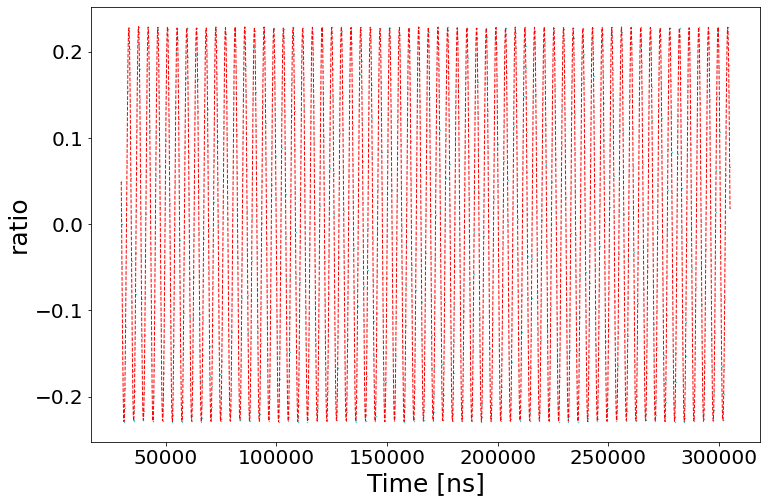

In [18]:
# Plot the noisy exponential data
plt.figure(figsize=(12,8))
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.scatter(x_val, y_val, s=0.1, color='#00b3b3', label='Data')
plt.plot(x_val, fit_func(x_val, *pars_final), linestyle='--', linewidth=1, color='red')
plt.xlabel('Time [ns]',fontsize=25)
plt.ylabel('ratio',fontsize=25)
#plt.ylim([0.0, 6000000000])
#plt.xlim([100000,150000])
plt.show()

In [19]:
# Calculate the residuals
res = (y_val - fit_func(x_val, *pars_final))/y_err

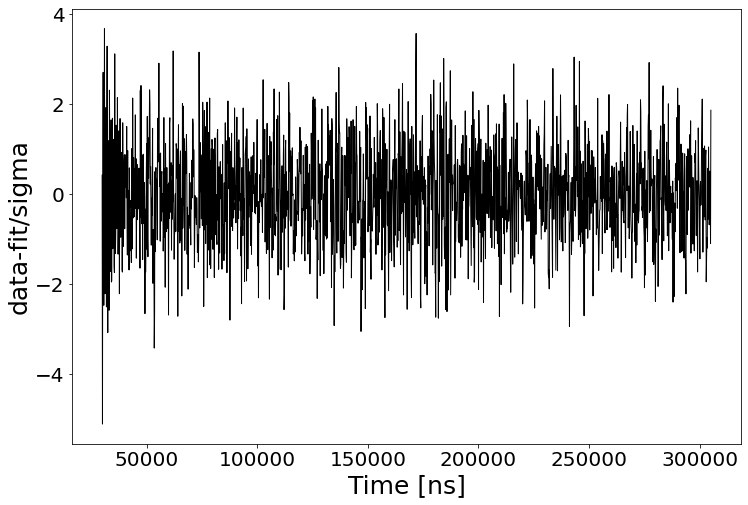

In [20]:
# Plot the noisy exponential data
plt.figure(figsize=(12,8))
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.plot(x_val, res, linestyle='solid', linewidth=1, color='black')
plt.xlabel('Time [ns]',fontsize=25)
plt.ylabel('data-fit/sigma',fontsize=25)
plt.savefig('run2all_res.jpg')

In [21]:
stdevs

array([1.32116143e-05, 3.84460169e-01, 5.86183462e-05, 2.01946952e-05,
       7.12710309e+03, 4.37405493e-07, 7.33343426e-02, 6.07150843e-05,
       1.65178616e-01, 6.18987228e-05, 7.19259413e-01, 3.59347705e-05,
       8.38605188e+03, 1.15095504e-06, 7.50924820e-02, 6.61683327e-04,
       1.00517539e+03, 4.19660351e-06, 1.55687939e-01, 1.31459132e-05,
       1.83793672e-01, 6.60292246e+07, 1.91317858e-03, 7.75195710e+03,
       1.14118263e-03, 3.13160958e-01, 1.29081334e-03])

In [22]:
fou=abs(np.fft.fft(res))

In [23]:
#xfft=np.empty(fit_range)
xfft= np.linspace(0,6.667,num=fit_range)
xfft[800]

2.9081788440567067

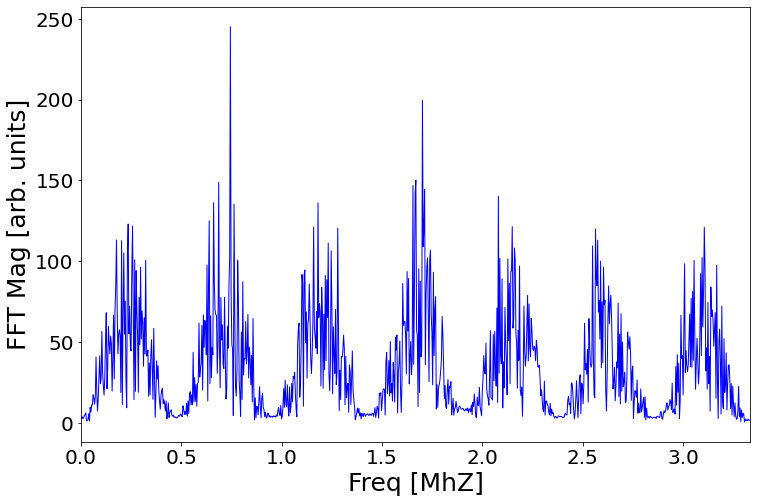

In [24]:
plt.figure(figsize=(12,8))
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.plot(xfft, fou, linestyle='solid', linewidth=1, color='blue')
plt.xlim([0,6.667/2])
plt.xlabel('Freq [MhZ]',fontsize=25)
plt.ylabel('FFT Mag [arb. units]',fontsize=25)
plt.savefig('run2all_fft.jpg')

In [25]:
chi2=np.dot((np.transpose(y_val-fit_func(x_val, *pars_final))),(np.dot((np.linalg.inv(y_cov)),(y_val-fit_func(x_val, *pars_final)))))

In [26]:
chi2

1847.4733418217893

In [27]:
ndf=fit_range-len(pars_final)

In [28]:
red_chi2=chi2/ndf

In [29]:
red_chi2

1.021832600565149

In [30]:
ndf

1808